In [1]:
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import scipy.optimize as opt

### 1. Load and Preprocess the data
We are going to work with the [Folktables](https://github.com/socialfoundations/folktables#quick-start-examples) dataset (*you have already worked with it*).

1. As last week, we are still predicting the *Total person's income*  (I've digitized  it in  `target_transform=lambda x: x > 25000`).
2. Today, we are going to implement two methods for data debiasing: [Fair PCA](https://deepai.org/publication/efficient-fair-pca-for-fair-representation-learning) and [A Geometric Solution to Fair Representations](https://dl.acm.org/doi/10.1145/3375627.3375864).
3. We are going to evaluate the performance on two sensitive features: `SEX` (i.e. *Males* and *Females*) and `RAC1P` (we will consider only *Whites* and *African-Americans*)
4. I updated the filtering method `adult_filter` to keep the specified groups.

In [2]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'CIT',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P'
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', "RAC1P"],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
# acs_data = acs_data.sample(500, random_state=0)

# 1.2 Proxies

## DO NOT OVERSAMPLE OR ANYTHING JUST LOOK AT RAW DATA

In [3]:
from sklearn.model_selection import train_test_split
data = ACSIncomeNew.df_to_pandas(acs_data)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data[0], data[1], data[2], test_size=0.2, random_state=0)

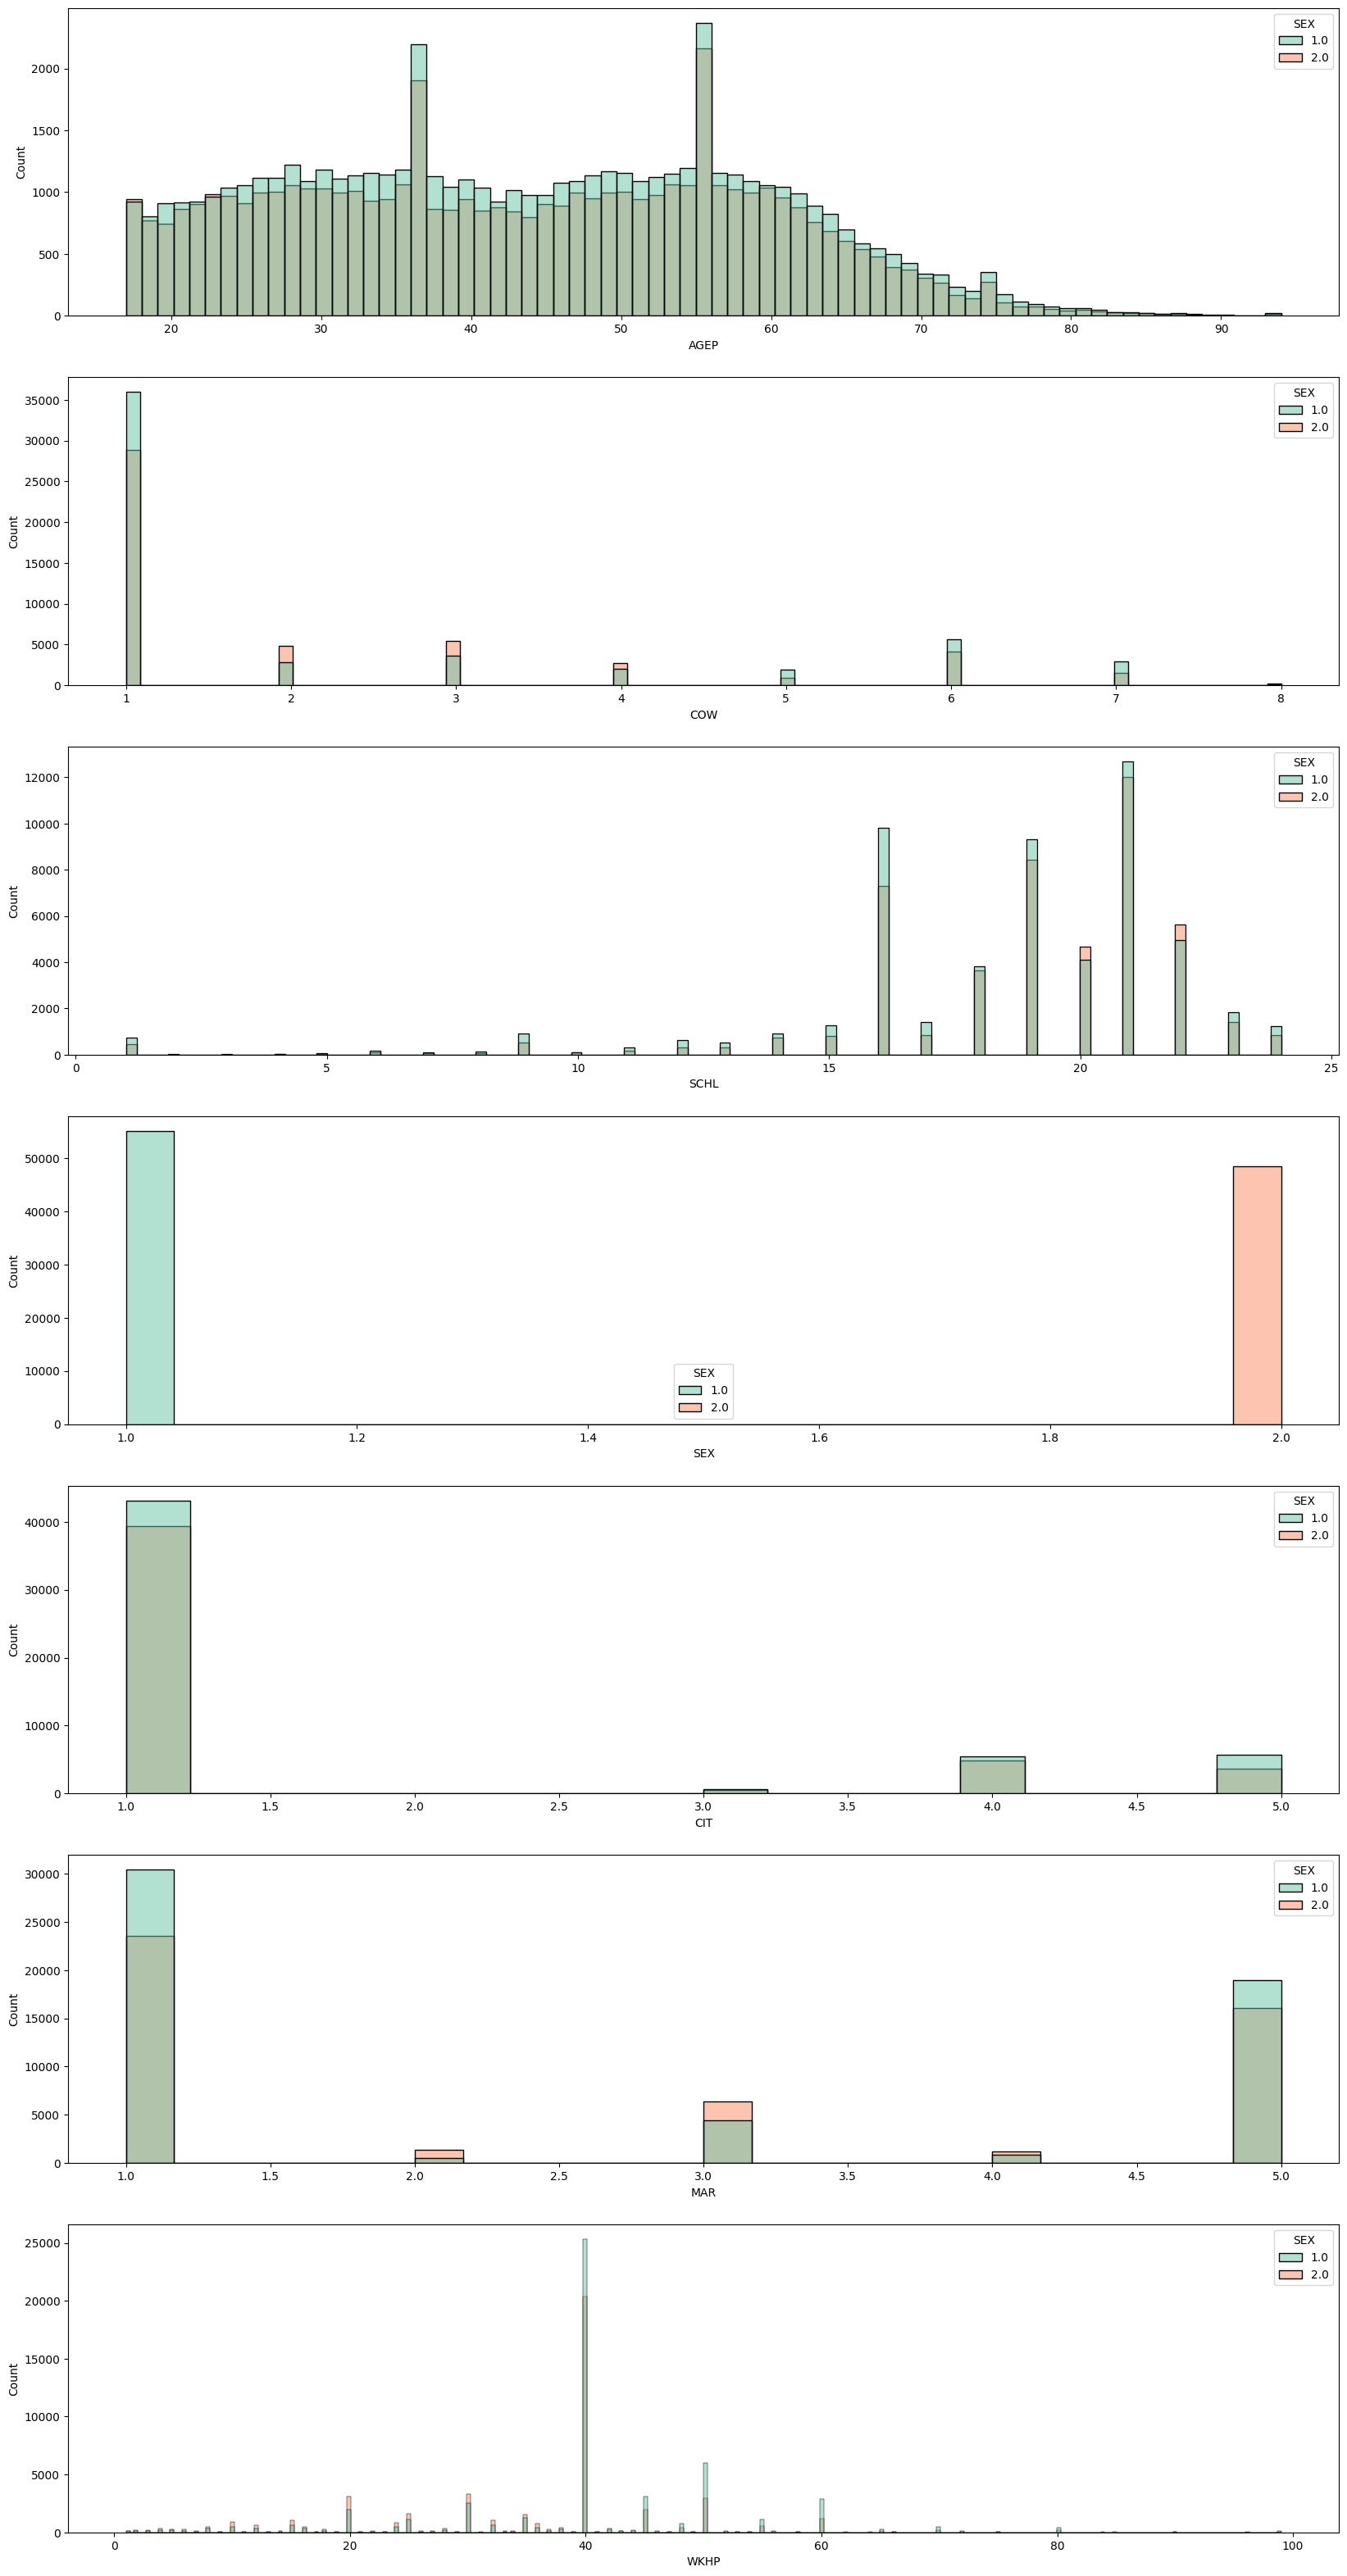

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot feature distributions for both genders in one plot
fig, axes = plt.subplots(7, figsize=(20, 40))
for i, feature in enumerate(['AGEP', 'COW', 'SCHL', 'SEX', 'CIT', 'MAR','WKHP']):
    sns.histplot(data=X_train, x=feature, hue='SEX', ax=axes[i], palette='Set2')
plt.show()

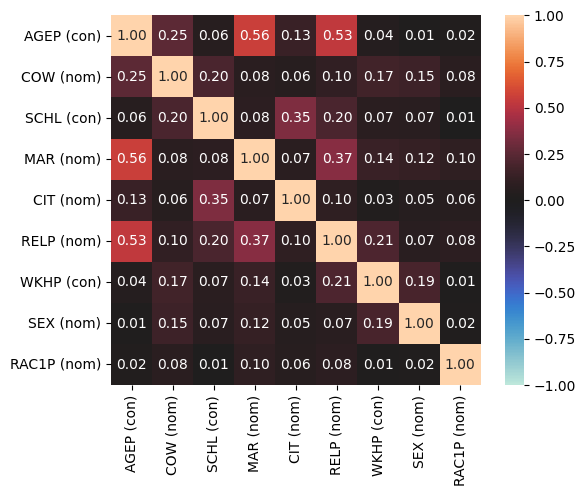

In [5]:
import dython
dython.nominal.associations(X_train, nominal_columns=['COW', 'CIT', 'RAC1P', 'SEX', 'RELP', 'MAR'], mark_columns=True);

# 2.1 Data

In [6]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)
### groups now contain information about SEX and RAC1P

In [7]:
# Drop the "redundant" columns
features = features.drop(["RELP_Unmarried partner",
                          "CIT_U.S. citizen by naturalization",
                          "SEX_Male",
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm', 
                          "RAC1P_White alone" ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)

Columns with the protected features:
Column ID: 56 (SEX_Female)
Column ID: 57 (RAC1P_Black or African American alone)


In [8]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

N = 500 ### I am subsampling because it is slow on my machine

X_train = X_train[:N]
y_train = y_train[:N]
group_train = group_train[:N]
X_test = X_test[:N]
y_test = y_test[:N]
group_test = group_test[:N]
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
## last columns of our data contains the protected features
protected = X_train[:,-2:] 
nonprotected = X_train[:,:-2]

protected_test = X_test[:,-2:]
nonprotected_test = X_test[:,:-2]

#### Task 2.2.
Use the following arguments in the `opt.fmin_funct`: `xtol=1e-4, ftol=1e-4,  maxfun=1000`

In [10]:
gammas = np.logspace(1e-5,1e-2,10)
###########
# YOUR CODE
###########

In [18]:
def sigmoid(x):
    """
    This is logistic regression
    f = 1/(1+exp(-beta^T * x))
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1/(1+np.exp(-x))

def logistic_loss(y_true, y_pred, eps = 1e-9):
    """
    Loss for the logistic regression, y_preds are probabilities
    eps: epsilon for stability
    """
    # check whether that's the same as 1/m * sum()
    return -np.mean(y_true*np.log(y_pred + eps)+(1-y_true)*np.log(1-y_pred + eps))
    
def l2_loss(beta):
    """
    L2-Regularisation
    """
    return np.linalg.norm(beta)

def compute_gradient(beta, X, y_true, _gamma): # y = y_true
    """Calculate the gradient - used for finding the best beta values. 
       You do not need to use groups and lambda (fmin_tnc expects same input as in func, that's why they are included here)"""
    grad = np.zeros(beta.shape)
    m = X.shape[0]
    y_pred = np.array(sigmoid(X.dot(beta))) # same as beta @ X.T?
    
    for i in range(len(grad)):
        if i == 0:
            # don't want to penalize the intercept
            grad[i] = (1/m) * (y_pred - y_true).dot(X[:,i]) 
        else:
            # start with beta[1]
            grad[i] = (1/m) * (y_pred - y_true).dot(X[:,i]) + 2* _gamma *beta[i] 
    #print(f'Gradient: {grad}')
    return grad

def compute_cost(beta , X, y_true, _gamma):
    """Computes cost function with constraints"""
    y_pred = sigmoid(X.dot(beta)) 
    cost = logistic_loss(y_true, y_pred) + _gamma*l2_loss(beta[1:]) # to not penalize the Intercept?
    #print(f'Cost: {cost}')
    return cost

beta = np.random.rand(X_train.shape[1])
# set parameters
lambda_ = 0.1
#
X = X_train
y = y_train
groups = group_train

beta = np.random.rand(56)


########## This is the optimisation function

# result = opt.fmin_tnc(func=compute_cost, x0=beta, approx_grad = True, maxfun = 1000,
#                          args = (nonprotected,y_train, gammas[i]), ftol=1e-4, xtol=1e-4)

In [19]:
import numpy as np

def cross_validate(X, y, penalty, k=5):
    """
    Performs k-fold cross-validation on logistic regression with L2-penalty
    
    X: feature matrix
    y: target variable
    penalty: L2-penalty value
    k: number of folds (default=5)
    
    Returns: average accuracy across all folds
    """
    n_samples = len(y)
    fold_size = n_samples // k
    
    accuracy_sum = 0
    
    for i in range(k):
        # split the data into training and validation sets
        val_start = i * fold_size
        val_end = (i + 1) * fold_size
        X_val = X[val_start:val_end]
        y_val = y[val_start:val_end]
        X_train = np.concatenate([X[:val_start], X[val_end:]])
        y_train = np.concatenate([y[:val_start], y[val_end:]])
        
        # fit logistic regression optimization function
        beta = np.random.rand(X_train.shape[1])
        result = opt.fmin_tnc(func=compute_cost, x0=beta, approx_grad = True, maxfun = 1000,
                            args = (X_train,y_train, penalty), ftol=1e-4, xtol=1e-4)
        beta = result[0]

        
        # evaluate model on validation set
        y_pred = sigmoid(X_val.dot(beta))
        y_pred = np.where(y_pred > 0.5, 1, 0)
        accuracy = np.mean(y_pred == y_val)
        accuracy_sum += accuracy
        
        
    accuracy_avg = accuracy_sum / k
    
    return accuracy_avg

In [20]:
penalties = [0.001, 0.01, 0.1, 1, 10]
best_penalty = None
best_accuracy = 0

for penalty in penalties:
    accuracy_avg = cross_validate(nonprotected, y_train, penalty)
    if accuracy_avg > best_accuracy:
        best_accuracy = accuracy_avg
        best_penalty = penalty
        
print("Best L2-penalty:", best_penalty)
print("Best accuracy:", best_accuracy)

Best L2-penalty: 0.01
Best accuracy: 0.7059999999999998


### 2.2.3

In [21]:
# Evaluate the overall performance of the best model on the Test Set (use appropriate metrics) + report uncertainty
# function for balanced accuracy
def balanced_accuracy(y_true, y_pred):
    """
    Calculates the balanced accuracy score
    """
    TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))
    
    accuracy = (TP/(TP+FN) + TN/(TN+FP)) / 2
    return accuracy

result = opt.fmin_tnc(func=compute_cost, x0=beta, approx_grad = True, maxfun = 1000,
                            args = (nonprotected,y_train, best_penalty), ftol=1e-4, xtol=1e-4)
beta = result[0]

# evaluate the model on the test set using balanced accuracy
y_pred = sigmoid(nonprotected_test.dot(beta))
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = balanced_accuracy(y_test, y_pred)
print("Balanced accuracy on test set:", accuracy)

# calculate precision by hand
TP = np.sum(np.logical_and(y_pred == 1, y_test == 1))
FP = np.sum(np.logical_and(y_pred == 1, y_test == 0))
precision = TP / (TP + FP)
print("Precision on test set:", precision)

# calculate recall by hand
TP = np.sum(np.logical_and(y_pred == 1, y_test == 1))
FN = np.sum(np.logical_and(y_pred == 0, y_test == 1))
recall = TP / (TP + FN)
print("Recall on test set:", recall)

# calculate F1 score by hand
F1 = 2 * (precision * recall) / (precision + recall)
print("F1 score on test set:", F1)

# calculate uncertainty by bootstrapping
n_bootstraps = 1000
bootstrapped_scores = []
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(low=0, high=len(y_pred), size=len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = balanced_accuracy(y_test[indices], y_pred[indices])
    bootstrapped_scores.append(score)

print("Confidence interval for the accuracy score: [{:0.3f} - {:0.3}]".format(
    np.percentile(bootstrapped_scores, 2.5),
    np.percentile(bootstrapped_scores, 97.5)))

Balanced accuracy on test set: 0.6823809523809523
Precision on test set: 0.8467432950191571
Recall on test set: 0.6314285714285715
F1 score on test set: 0.723404255319149
Confidence interval for the accuracy score: [0.639 - 0.725]


### 2.2.4

In [22]:
# caluclate statistical parity, equalized odds and equalized outcome for all groups
def calculate_metrics(y_true, y_pred, groups):
    """
    Calculate statistical parity, equalized odds and equalized outcome for all groups
    """
    metrics = {}
    for group in groups:
        for i in [1,2]:
            group_idx = np.where(groups[group] == i)
            y_true_group = y_true[group_idx]
            y_pred_group = y_pred[group_idx]
            g = group + str(i)
            metrics[g] = {}
            metrics[g]['statistical_parity'] = np.mean(y_pred_group)
            metrics[g]['equalized_odds'] = np.mean(y_pred_group[y_true_group == 1]) - np.mean(y_pred_group[y_true_group == 0])
            metrics[g]['equalized_outcome'] = np.mean(y_pred_group[y_true_group == 1])
    return metrics

In [23]:
# calculate metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
metrics = calculate_metrics(y_test, y_pred, group_test)
print(metrics)

{'SEX1': {'statistical_parity': 0.5824175824175825, 'equalized_odds': 0.3729814593301436, 'equalized_outcome': 0.6698564593301436}, 'SEX2': {'statistical_parity': 0.44933920704845814, 'equalized_odds': 0.33028203859475513, 'equalized_outcome': 0.574468085106383}, 'RAC1P1': {'statistical_parity': 0.5297872340425532, 'equalized_odds': 0.3577922077922078, 'equalized_outcome': 0.6363636363636364}, 'RAC1P2': {'statistical_parity': 0.4, 'equalized_odds': 0.45000000000000007, 'equalized_outcome': 0.55}}


#### Task 2.3
Use the following arguments in the `opt.fmin_funct`: ` xtol=1e-3, ftol=1e-3, approx_grad=True, maxfun=1000`

In [24]:
lambdas = np.array([1e-3, 5e-3, 1e-2, 5e-2, 0.1, 1])
###########
# YOUR CODE
###########

In [25]:
### Model with Fair Penalty
def sigmoid(x):
    """
    This is logistic regression
    f = 1/(1+exp(-beta^T * x))
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1/(1+np.exp(-x))

def logistic_loss(y_true, y_pred, eps = 1e-9):
    """
    Loss for the logistic regression, y_preds are probabilities
    eps: epsilon for stability
    """
    # check whether that's the same as 1/m * sum()
    return -np.mean(y_true*np.log(y_pred + eps)+(1-y_true)*np.log(1-y_pred + eps))
    
def l2_loss(beta):
    """
    L2-Regularisation
    """
    return np.linalg.norm(beta)

# TODO:
# If you use this implementation, please, provide comments per line (aka what each line does)
def fair_loss(y, y_pred, groups):
    """
    Group fairness Loss
    """
    n = y.shape[0]
    n1 = np.sum(groups == 1)
    n2 = np.sum(groups == 2)
    cost = 0
    groups = np.array(groups)
    equal_pairs = np.argwhere(y[np.newaxis, :] == y[:, np.newaxis])
    equal_pairs = equal_pairs[np.where(equal_pairs[:,0] != equal_pairs[:,1])] 
    diff_groups = (groups[equal_pairs[:,0]] != groups[equal_pairs[:,1]]).astype(int) 
    cost = diff_groups.dot((y_pred[equal_pairs[:,0]] - y_pred[equal_pairs[:,1]])**2) ## 
    cost = cost/(n1*n2)
    return cost


### not needed (?)
def compute_gradient(beta,X,y_true,_gamma): # y = y_true
    """Calculate the gradient - used for finding the best beta values. 
       You do not need to use groups and lambda (fmin_tnc expects same input as in func, that's why they are included here)"""
    grad = np.zeros(beta.shape)
    m = X.shape[0]
    y_pred = np.array(sigmoid(X.dot(beta))) # same as beta @ X.T?
    
    for i in range(len(grad)):
        if i == 0:
            # don't want to penalize the intercept
            grad[i] = (1/m) * (y_pred - y_true).dot(X[:,i]) 
        else:
            # start with beta[1]
            grad[i] = (1/m) * (y_pred - y_true).dot(X[:,i]) + 2* _gamma *beta[i] 
    #print(f'Gradient: {grad}')
    return grad


def compute_cost(beta , X, y_true, grouping, _lambda, _gamma):
    """Computes cost function with constraints"""
    y_pred = sigmoid(X.dot(beta)) 
    cost = logistic_loss(y_true, y_pred) + _lambda*fair_loss(y_true, y_pred, grouping['SEX']) + _lambda*fair_loss(y_true, y_pred, grouping['RAC1P']) + _gamma*l2_loss(beta[1:]) # to not penalize the Intercept?
    #print(f'Cost: {cost}')
    return cost

In [26]:
# runs for 20+ minutes
np.random.seed(0)
lambdas = np.array([1e-3, 5e-3, 1e-2, 5e-2, 0.1, 1])
betas = np.random.rand(nonprotected.shape[1])

results = []
for lambda_ in lambdas:
    result = opt.fmin_tnc(func=compute_cost, x0=betas, approx_grad=True, maxfun=1000,
                          args=(nonprotected, y_train, group_train, lambda_, best_penalty), 
                          ftol=1e-4, xtol=1e-4)
    results.append(result[0])

In [27]:
# test results for each group on test data

# too tired need to fix it so it makes a list of results per lambda
# then we take the results per lambda and align the results to the groups to get a pareto curve

acc_scores = {}
for group in group_test:
    for i in [1,2]:
            group_idx = np.where(group_test[group] == i)
            g = group + str(i)
            acc_scores[g] = {}
            for i, lambda_ in enumerate(lambdas):
                y_pred = sigmoid(nonprotected_test.dot(results[i]))
                y_pred = np.array([1 if y >= 0.5 else 0 for y in y_pred])
                y_pred_group = y_pred[group_idx]
                y_test_group = y_test[group_idx]
                acc_scores[g][lambda_] = balanced_accuracy(y_test_group, y_pred_group)


In [28]:
acc_scores

{'SEX1': {0.001: 0.736244019138756,
  0.005: 0.7320947966507176,
  0.01: 0.7738860645933014,
  0.05: 0.7793062200956937,
  0.1: 0.7067508971291866,
  1.0: 0.7708582535885167},
 'SEX2': {0.001: 0.7509483753917203,
  0.005: 0.7222909450766947,
  0.01: 0.7960580570674584,
  0.05: 0.7889658584858981,
  0.1: 0.714497773379515,
  1.0: 0.7866980042883062},
 'RAC1P1': {0.001: 0.7474025974025974,
  0.005: 0.7359307359307359,
  0.01: 0.7866883116883117,
  0.05: 0.7857142857142858,
  0.1: 0.7163419913419914,
  1.0: 0.7795454545454545},
 'RAC1P2': {0.001: 0.75,
  0.005: 0.7250000000000001,
  0.01: 0.8,
  0.05: 0.8,
  0.1: 0.775,
  1.0: 0.825}}

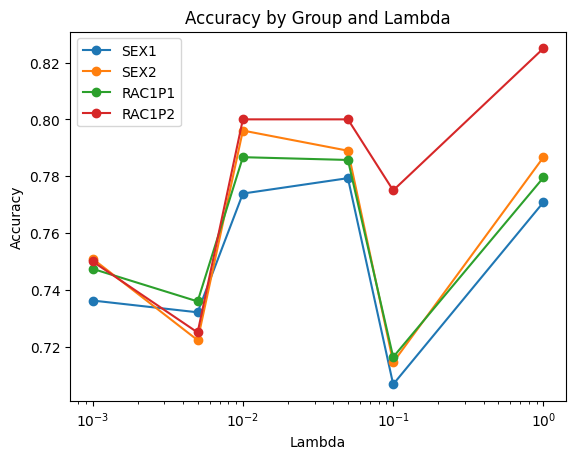

In [29]:
import matplotlib.pyplot as plt
# pareto curve of acc_scores
# Extract the groups and parameter values
# Extract the groups and parameter values
groups = list(acc_scores.keys())
params = list(acc_scores[groups[0]].keys())

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each group
for i, group in enumerate(groups):
    acc_values = list(acc_scores[group].values())
    ax.plot(params, acc_values, marker='o', label=group)

# Set the axis labels and title
ax.set_xlabel('Lambda')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Group and Lambda')

# make x axis log scale along values of lambda
ax.set_xscale('log')

# Add a legend
ax.legend()

# Show the plot
plt.show()

### 2.3.3

In [31]:
# evaluate the model on the test set using balanced accuracy
beta = np.random.rand(nonprotected.shape[1])

result = opt.fmin_tnc(func=compute_cost, x0=beta, approx_grad=True, maxfun=1000,
                        args=(nonprotected, y_train, group_train, 0.1, best_penalty),
                        ftol=1e-4, xtol=1e-4, disp=True)

In [32]:

beta = result[0]
y_pred = sigmoid(nonprotected_test.dot(beta))
y_pred = np.where(y_pred > 0.5, 1, 0)


accuracy = balanced_accuracy(y_test, y_pred)
print("Balanced accuracy on test set:", accuracy)

# calculate precision by hand
TP = np.sum(np.logical_and(y_pred == 1, y_test == 1))
FP = np.sum(np.logical_and(y_pred == 1, y_test == 0))
precision = TP / (TP + FP)
print("Precision on test set:", precision)

# calculate recall by hand
TP = np.sum(np.logical_and(y_pred == 1, y_test == 1))
FN = np.sum(np.logical_and(y_pred == 0, y_test == 1))
recall = TP / (TP + FN)
print("Recall on test set:", recall)

# calculate F1 score by hand
F1 = 2 * (precision * recall) / (precision + recall)
print("F1 score on test set:", F1)

# calculate uncertainty by bootstrapping
n_bootstraps = 1000
bootstrapped_scores = []
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(low=0, high=len(y_pred), size=len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = balanced_accuracy(y_test[indices], y_pred[indices])
    bootstrapped_scores.append(score)

print("Confidence interval for the accuracy score: [{:0.3f} - {:0.3}]".format(
    np.percentile(bootstrapped_scores, 2.5),
    np.percentile(bootstrapped_scores, 97.5)))

Balanced accuracy on test set: 0.7857142857142858
Precision on test set: 0.9
Recall on test set: 0.7714285714285715
F1 score on test set: 0.8307692307692307
Confidence interval for the accuracy score: [0.750 - 0.822]


### 2.3.4

In [34]:
# calculate metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
metrics = calculate_metrics(y_test, y_pred, group_test)
print(metrics)

{'SEX1': {'statistical_parity': 0.6483516483516484, 'equalized_odds': 0.5407446172248804, 'equalized_outcome': 0.7751196172248804}, 'SEX2': {'statistical_parity': 0.5418502202643172, 'equalized_odds': 0.5915388421573479, 'equalized_outcome': 0.7659574468085106}, 'RAC1P1': {'statistical_parity': 0.6, 'equalized_odds': 0.5696969696969696, 'equalized_outcome': 0.7696969696969697}, 'RAC1P2': {'statistical_parity': 0.6, 'equalized_odds': 0.6000000000000001, 'equalized_outcome': 0.8}}


## Task 2.4: Fair PCA 
#### Everything besides 2.4.4 works now (even if results are worse) we shouldn't touch it anymore I guess

In [35]:
definition_df = data_source.get_definitions(download=True)
#categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)

### groups now contain information about SEX and RAC1P
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

N = 500 ### I am subsampling because it is slow on my machine

X_train = X_train[:N]
y_train = y_train[:N]
group_train = group_train[:N]
X_test = X_test[:N]
y_test = y_test[:N]
group_test = group_test[:N]

Columns with the protected features:
Column ID: 58 (SEX_Female)
Column ID: 59 (RAC1P_Black or African American alone)


In [36]:
protected = X_train[:,-2:]
nonprotected = X_train[:,:-2]

Text(0.5, 0, 'Principal Component')

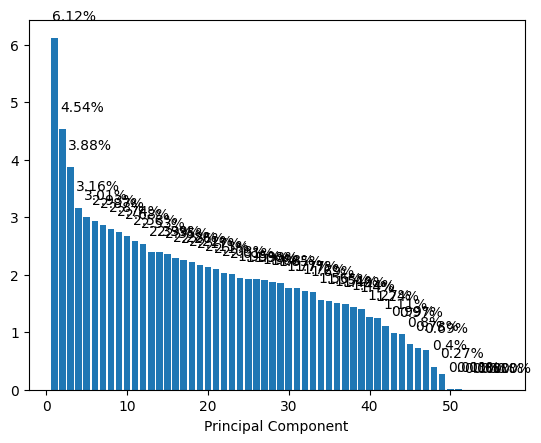

In [37]:
# pca 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# normalize first two columns for age and wkhp
non_protected_features_scaled = nonprotected.copy()
non_protected_features_scaled = scaler.fit_transform(nonprotected)

pca = PCA(n_components=len(features.columns)-4) # - protected features
X_pca = pca.fit_transform(non_protected_features_scaled)

# pca.explained_variance_ratio_
# scree plot bar plot
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_*100)
for i in range(len(pca.explained_variance_ratio_)):
    plt.text(i+0.7, pca.explained_variance_ratio_[i]*100+0.3, str(round(pca.explained_variance_ratio_[i]*100,2))+'%')
plt.xlabel('Principal Component')

In [38]:
# plot the first three components interactive 3d
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=X_pca[:,0],
    y=X_pca[:,1],
    z=X_pca[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=['red' if x else 'blue' for x in y_train], # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])
fig.show()

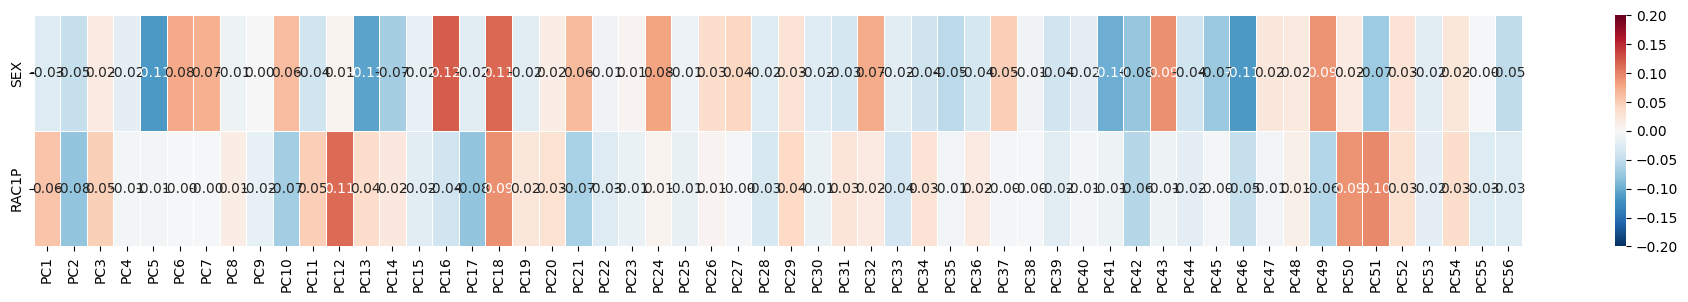

In [84]:
# corr matrix comparing protected
import seaborn as sns
import pandas as pd

df = pd.DataFrame(np.concatenate((protected, X_pca), axis=1))

corr = df.corr()
corr.columns=['SEX', 'RAC1P', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37', 'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'PC43', 'PC44', 'PC45', 'PC46', 'PC47', 'PC48', 'PC49', 'PC50', 'PC51', 'PC52', 'PC53', 'PC54', 'PC55', 'PC56']

rows_to_plot = [x for x in corr.columns if "PC" in x]
indices_to_plot = range(2)
corr = corr.loc[indices_to_plot, rows_to_plot]
indices = ["SEX", "RAC1P"]
corr.index = indices
plt.figure(figsize=(24, 3))
sns.heatmap(corr,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            vmin=-0.2,
            vmax=0.2,
            fmt='.2f');

## 2.4.2

In [40]:
# project test data with pca
nonprotected_test = X_test[:,:-2]
non_protected_features_scaled_test = nonprotected_test.copy()

# normalize first two columns for age and wkhp
non_protected_features_scaled_test = scaler.transform(nonprotected_test)
X_pca_test = pca.transform(non_protected_features_scaled_test)

# project it back into the original space
X_reconstructed = pca.inverse_transform(X_pca)
X_reconstructed_test = pca.inverse_transform(X_pca_test)

# calculate reconstruction error for each sample as mean absolute error
reconstruction_error = []
for i in range(len(non_protected_features_scaled)):
    reconstruction_error.append(np.mean(np.abs(non_protected_features_scaled[i] - X_reconstructed[i])))
reconstruction_error_test = []
for i in range(len(non_protected_features_scaled_test)):
    reconstruction_error_test.append(np.mean(np.abs(non_protected_features_scaled_test[i] - X_reconstructed_test[i])))

# get reconstruction error for protected features
female_error = []
male_error = []
whites_error = []
african_american_error = []
for i in range(len(reconstruction_error_test)):
    # person is always member of both protected groups

    # 1 is male and 2 is female
    if protected[i][0] == 1:
        male_error.append(reconstruction_error_test[i])
    else:
        female_error.append(reconstruction_error_test[i])

    # 1 is white and 2 is african american
    if protected[i][1] == 1:
        whites_error.append(reconstruction_error_test[i])
    else:
        african_american_error.append(reconstruction_error_test[i])

# calculate mean reconstruction error for each group
print(np.mean(male_error))
print(np.mean(female_error))
print(np.mean(whites_error))
print(np.mean(african_american_error))


6.625753579049534e-06
2.9555333635884288e-05
1.1841326111966275e-15
2.0560878792845903e-05


## 2.4.3 Fair PCA

In [77]:
import scipy
X = non_protected_features_scaled.copy()
# create Matrix Z with protected features
Z = protected.copy()
# remove mean from each column
Z = Z - np.mean(Z, axis=0)
# find orthonormal null space spanned by ZTX with scipy.linalg.null_space
R = scipy.linalg.null_space(Z.T @ X)

# Find orthonormal eigenvectors RTXTXR with scipy.linalg.eig
eigvals, eigvecs = scipy.linalg.eig(R.T @ X.T @ X @ R)
# sort eigenvectors by eigenvalues
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

# get matrix of first 50 eigenvectors (the others were 0)
L = eigvecs[:,:50]

# projection matrix U = RL
U = R @ L

# project data
X_projected = X @ U


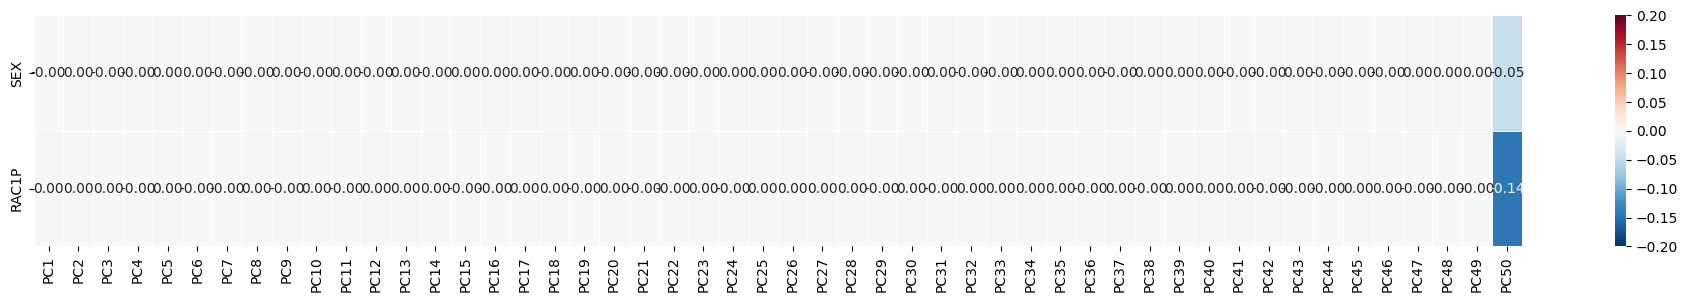

In [83]:
# corr matrix comparing protected
import seaborn as sns
import pandas as pd

df = pd.DataFrame(np.concatenate((Z, X_projected), axis=1))

corr = df.corr()
corr.columns=['SEX', 'RAC1P', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37', 'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'PC43', 'PC44', 'PC45', 'PC46', 'PC47', 'PC48', 'PC49', 'PC50']
rows_to_plot = [x for x in corr.columns if "PC" in x]
indices_to_plot = range(2)
corr = corr.loc[indices_to_plot, rows_to_plot]
indices = ["SEX", "RAC1P"]
corr.index = indices
plt.figure(figsize=(24, 3))
sns.heatmap(corr,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            vmin=-0.2,
            vmax=0.2,
            fmt='.2f');


### 2.4.4

In [42]:
# project test data
X_test_projected = non_protected_features_scaled_test @ U

# reproject it back into the original space
X_reconstructed = X_projected @ U.T
X_reconstructed_test = X_test_projected @ U.T

# calculate reconstruction error for each sample as mean absolute error
reconstruction_error = []
for i in range(len(non_protected_features_scaled)):
    reconstruction_error.append(np.mean(np.abs(non_protected_features_scaled[i] - X_reconstructed[i])))
reconstruction_error_test = []
for i in range(len(non_protected_features_scaled_test)):
    reconstruction_error_test.append(np.mean(np.abs(non_protected_features_scaled_test[i] - X_reconstructed_test[i])))
# get reconstruction error for protected features
female_error = []
male_error = []
whites_error = []
african_american_error = []
for i in range(len(reconstruction_error_test)):
    # person is always member of both protected groups

    # 1 is male and 2 is female
    if protected[i][0] == 1:
        male_error.append(reconstruction_error_test[i])
    else:
        female_error.append(reconstruction_error_test[i])

    # 1 is white and 2 is african american
    if protected[i][1] == 1:
        whites_error.append(reconstruction_error_test[i])
    else:
        african_american_error.append(reconstruction_error_test[i])

# calculate mean reconstruction error for each group
print(np.mean(male_error))
print(np.mean(female_error))
print(np.mean(whites_error))
print(np.mean(african_american_error))

0.1515667962088425
0.1470776787390255
0.18453433099881916
0.14608465517947286


## 2.5

In [43]:
# fit own implementation of logistic regression on projected data

beta = np.random.rand(54)

result = opt.fmin_tnc(func=compute_cost, x0=beta, approx_grad = True, maxfun = 1000,
                         args = (X_projected, y_train, groups, lambda_, 0), ftol=1e-4, xtol=1e-4) # 0 for no regularization

In [ ]:
# evaluate on test data by multiplying with result vector
# y_pred = X_test_projected @ result
y_hat = X_test_projected.dot(result[0])
y_pred = np.where(y_hat > 0.5, 1, 0)

# calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(accuracy)